### Import libraries

In [1]:
import time
import os
import pandas as pd
import configparser
import requests

Activate the interactive mode for all series and dataframes

In [2]:
import itables.options as opt

opt.maxBytes = "1MB"


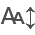

In [3]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

In [4]:
from itables import show

Get credentials

In [5]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

### Gather data and prepare it

Get data from EIPA API

In [6]:
# GET pools and stations from api,
headers = {
    "Content-Type": "application/json, charset=utf-8",
    "Accept": "application/json"
}

get_eipa_public_pools = requests.get(config['API EIPA Public']['endpoint_pools'], headers=headers).json()
get_eipa_public_stations = requests.get(config['API EIPA Public']['endpoint_stations'], headers=headers).json()
get_eipa_public_points = requests.get(config['API EIPA Public']['endpoint_points'], headers=headers).json()
get_eipa_public_operators = requests.get(config['API EIPA Public']['endpoint_operators'], headers=headers).json()
get_eipa_public_dictionary = requests.get(config['API EIPA Public']['endpoint_dictionary'], headers=headers).json()

Convert to dataframe

In [7]:
df_eipa_pools = pd.json_normalize(get_eipa_public_pools, record_path=['data'])
df_eipa_stations = pd.json_normalize(get_eipa_public_stations, record_path=['data'])
df_eipa_points = pd.json_normalize(get_eipa_public_points, record_path=['data'])
df_eipa_operators = pd.json_normalize(get_eipa_public_operators, record_path=['data'])
df_eipa_dictionary = pd.json_normalize(get_eipa_public_dictionary, record_path=['charging_mode'])

Create copies of the original dataframes in case of overriding them

In [8]:
df_pools = df_eipa_pools.copy()

In [9]:
df_stations = df_eipa_stations.copy()

In [10]:
df_operators = df_eipa_operators.copy().reset_index(drop=True)

In [11]:
df_dictionary = df_eipa_dictionary.copy()

In [12]:
df_points = df_eipa_points.copy().reset_index(drop=True)

### Analyze the data

Let's display all the dataframes to see how they look like and find matching keys

In [13]:
df_pools.head(5)

operator_id  charging  refilling  h2refilling  features  legalized  \
0            4      True      False        False  [energy]       True   
1            4      True      False        False  [energy]       True   
2            4      True      False        False  [energy]       True   
3            4      True      False        False  [energy]       True   
4            4      True      False        False  [energy]       True   

   filling              code   id                                        name  \
0    False  PL-GJC-PEVP01004  242           Hotel HP PARK  stacja testowa EV+   
1    False  PL-GJC-PEVP01008  246                            UM Wągrowiec EV+   
2    False  PL-GJC-PEVP01013  250  Stacja Paliw Moc Jakość Zysk Korzeńsko EV+   
3    False  PL-GJC-PEVP01014  251                  Business Garden Poznań EV+   
4    False  PL-GJC-PEVP01015  252                IWBC Power Bielsko-Biała EV+   

   ...                         ts  operator_name  operator_phone  \
0  ...  2019-04-25T11:46:36+02:00            NaN             NaN   
1  ...  2019-04-25T11:46:58+02:00            NaN             NaN   
2  ...  2019-04-25T11:47:19+02:00            NaN             NaN   
3  ...  2019-04-25T11:47:25+02:00            NaN             NaN   
4  ...  2023-08-03T14:31:47+02:00            NaN             NaN   

  operator_website operator_email house_number_addition features.0 features.1  \
0              NaN            NaN                   NaN        NaN        NaN   
1              NaN            NaN                   NaN        NaN        NaN   
2              NaN            NaN                   NaN        NaN        NaN   
3              NaN            NaN                   NaN        NaN        NaN   
4              NaN            NaN                   NaN        NaN        NaN   

  features.3 teryt  
0        NaN   NaN  
1        NaN   NaN  
2        NaN   NaN  
3        NaN   NaN  
4        NaN   NaN  

[5 rows x 31 columns]

In [14]:
df_pools.shape

(3521, 31)

Pools dataframe shows you list of locations. As you can see, it refers to Operators dataframe by operator_id column.

In [15]:
df_stations.head()

authentication_methods  pool_id payment_methods  longitude   latitude    id  \
0                [0, 32]      242          [1, 2]  16.972012  52.400204  1155   
1                [0, 32]      242          [1, 2]  16.972012  52.400204  1156   
2                [0, 32]      246          [1, 2]  17.200867  52.809794  1161   
3                [0, 32]      250          [1, 2]  16.875305  51.552733  1167   
4                [0, 32]      251          [1, 2]  16.865844  52.405501  1168   

  type images                         ts location.province location.district  \
0    E     []  2024-07-23T05:26:40+02:00     wielkopolskie            Poznań   
1    E     []  2024-07-23T05:26:40+02:00     wielkopolskie            Poznań   
2    E     []  2023-11-10T05:50:37+01:00     wielkopolskie       wągrowiecki   
3    E     []  2023-11-10T05:50:53+01:00      dolnośląskie        trzebnicki   
4    E     []  2023-11-10T05:51:00+01:00     wielkopolskie            Poznań   

  location.community location.city  
0             Poznań        Poznań  
1             Poznań        Poznań  
2          Wągrowiec     Wągrowiec  
3            Żmigród     Korzeńsko  
4             Poznań        Poznań

In [16]:
df_stations.shape

(4355, 13)

Stations dataframe shows all the stations. As you can see, it refers to Pools dataframe by pool_id column.

In [17]:
df_operators.head()

id                                             name    code  \
0   3                                 Wenar Sp. z o.o.  PL-WEN   
1   4  EV PLUS Spółka z ograniczoną odpowiedzialnością  PL-GJC   
2   5                       GreenWay Polska Sp. z o.o.  PL-7R5   
3   6                             GO+ EAuto sp. z o.o.  PL-MYE   
4   7   NEXITY Spółka z ograniczoną odpowiedzialnością  PL-37C   

             phone                  email                      website  \
0        780070766          info@wenar.pl        https://www.e-mob.pl/   
1        533708555    biuro@evplus.com.pl         http://evplus.com.pl   
2  48-58-325-10-17  bok@greenwaypolska.pl    http://greenwaypolska.pl/   
3        515515243   biuro@gopluseauto.pl  https://www.gopluseauto.pl/   
4     +48691091191      support@nexity.io                          NaN   

           short_name  type country  
0               Wenar     1      pl  
1  EV PLUS Sp. z o.o.     1      pl  
2                GWPL     1      pl  
3           GO+ EAuto     1      pl  
4              NEXITY     3      pl

In Operators dataframe you can see columns "name" and "short_name". Let's see if there are any missing values.

In [18]:
df_operators.count()

id            557
name          557
code          557
phone         557
email         513
website       403
short_name    408
type          557
country       557
dtype: int64

Column "name" is filled properly as expected, beacuase it contains the full names of the operators. However, not every operator has a short name. Which one exactly? Let's find out.

In [19]:
df_operators.loc[df_operators["short_name"].isna()]

id                              name    code            phone  \
16     21  Gmina Miasto Ostrów Wielkopolski  PL-X2P     62 58-22-207   
32     41                Energa Obrót S. A.  PL-KM8      555-555-537   
33     42                 IMPWAR SP. Z O.O.  PL-NQN        601901602   
36     46           Gmina Miejska Legionowo  PL-HA6        227664068   
41     52                Playada Sp. z o.o.  PL-15Y      734-188-493   
..    ...                               ...     ...              ...   
543  1751     Natural Hotel Group Sp. z o.o  PL-YTD     +48451596932   
547  1756                          Lek S.A.  PL-5A6     +48667607522   
548  1757                          Bruk-Pro  PL-MHB     +48721067017   
550  1759            GMINA MIASTO KOŁOBRZEG  PL-E63     +48943551510   
551  1760            Fiedorowicz Sp. z o.o.  PL-8FK  +48-532-127-490   

                              email  \
16           mspizewska@umostrow.pl   
32              emobility@energa.pl   
33                bielany@impwar.pl   
36       inwestycje@um.legionowo.pl   
41                wkmiec@playada.pl   
..                              ...   
543           event@naturalhotel.pl   
547  arkadiusz.sukiennik@sandoz.com   
548            brukpro.sp@gmail.com   
550           urzad@um.kolobrzeg.pl   
551        p.kaminski@polbisauto.pl   

                                               website short_name  type  \
16                                                 NaN        NaN     1   
32                               https://emobility.pl/        NaN     1   
33                                                 NaN        NaN     1   
36                                                 NaN        NaN     1   
41                                                 NaN        NaN     1   
..                                                 ...        ...   ...   
543                                                NaN        NaN     3   
547                             https://www.sandoz.pl/        NaN     1   
548  https://geoportal.wroclaw.pl/poi/pt/20884/ul.K...        NaN     3   
550                         http://bip.um.kolobrzeg.pl        NaN     1   
551                      http://fiedorowicz.olsztyn.pl        NaN     1   

    country  
16       pl  
32       pl  
33       pl  
36       pl  
41       pl  
..      ...  
543      pl  
547      pl  
548      pl  
550      pl  
551      pl  

[149 rows x 9 columns]

In [20]:
df_operators.shape

(557, 9)

Operators dataframe shows all the operators. It does not depend on other dataframes, other dataframes depend on this one. Hence we will use column "id" to merge names of the operators from this dataframe with details about stations etc.

In [21]:
df_dictionary

id         name
0   1  Mode1-AC-1p
1   2  Mode1-AC-3p
2   3  Mode2-AC-1p
3   4  Mode2-AC-3p
4   5  Mode3-AC-1p
5   6  Mode3-AC-3p
6   7     Mode4-DC

Dictionary dataframe shows information about type of plug. We will not focus too much on specific type of plug like CCS, CHAdeMO or Type 2 Plug, but rather whetere they are AC or DC type. As we are talking about plug types, we have to refer to charge points to merge the dataframe. Why charge points, not connectors? Because one station may have more connectors than charge points. Data we've got from EIPA contains all the charge points reported by operators, not all the existing connectors.

In [22]:
df_points.head()

gas_connector_interfaces hydrogen_refill_solutions fuel_types  station_id  \
0                       []                        []         []        1155   
1                       []                        []         []        1156   
2                       []                        []         []        1161   
3                       []                        []         []        1161   
4                       []                        []         []        1167   

               code     id          charging_solutions  \
0  PL-GJC-EEVP01005  13480  [{'mode': 5, 'power': 11}]   
1  PL-GJC-EEVP01008  13481  [{'mode': 5, 'power': 11}]   
2  PL-GJC-EEVP01018  13493  [{'mode': 7, 'power': 40}]   
3  PL-GJC-EEVP01019  13494  [{'mode': 6, 'power': 22}]   
4  PL-GJC-EEVP01027  13501  [{'mode': 6, 'power': 22}]   

                          ts  \
0  2019-04-25T11:48:52+02:00   
1  2019-04-25T11:48:54+02:00   
2  2024-11-01T07:00:50+01:00   
3  2019-04-25T11:49:14+02:00   
4  2019-04-25T11:49:32+02:00   

                                          connectors max_output_unit gas_type  \
0  [{'interfaces': [10], 'power': 11, 'cable_atta...             NaN      NaN   
1  [{'interfaces': [10], 'power': 11, 'cable_atta...             NaN      NaN   
2  [{'interfaces': [29], 'power': 40, 'cable_atta...             NaN      NaN   
3  [{'interfaces': [17], 'power': 22, 'cable_atta...             NaN      NaN   
4  [{'interfaces': [10], 'power': 22, 'cable_atta...             NaN      NaN   

   max_output  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [23]:
df_points.shape

(8235, 12)

Points dataframe shows all the charge points. Here we can check what is the type of charge point, whether it is AC or DC. We can do it by look into "charging_solutions" column, which contains information about charge point type and it's power. 

### Merge tables

- operator - lista operatorów (id 5)
- pool - lista lokalizacji ("operator_id": 5, (code GWPL0002, id 65, code GWPL0004, id 67)) - łączone z operator po "id" i "operator_id"
- station - lista stacji (pool_id 65 "id": 103018 ) (pool_id 67, "id": 103021 oraz "id": 110264) - łączone z pool po "id" i "pool id"
- point - lista punktów ładowania ("station_id": 103021, ("code": "PL-7R5-EL0004112", "id": 283754), ("code": "PL-7R5-EL0004121", "id": 283755)) - łączone ze station po "id" i "station_id"

In [24]:
print(df_pools.columns)
print(df_stations.columns)
print(df_operators.columns)
print(df_dictionary.columns)
print(df_points.columns)

Index(['operator_id', 'charging', 'refilling', 'h2refilling', 'features',
       'legalized', 'filling', 'code', 'id', 'name', 'latitude', 'longitude',
       'elevation', 'street', 'house_number', 'postal_code', 'city',
       'accessibility', 'operating_hours', 'closing_hours', 'images', 'ts',
       'operator_name', 'operator_phone', 'operator_website', 'operator_email',
       'house_number_addition', 'features.0', 'features.1', 'features.3',
       'teryt'],
      dtype='object')
Index(['authentication_methods', 'pool_id', 'payment_methods', 'longitude',
       'latitude', 'id', 'type', 'images', 'ts', 'location.province',
       'location.district', 'location.community', 'location.city'],
      dtype='object')
Index(['id', 'name', 'code', 'phone', 'email', 'website', 'short_name', 'type',
       'country'],
      dtype='object')
Index(['id', 'name'], dtype='object')
Index(['gas_connector_interfaces', 'hydrogen_refill_solutions', 'fuel_types',
       'station_id', 'code', 'id', 'c

At first lets add location details to stations

In [25]:
stations_merged_df = pd.merge(df_stations, df_pools, how='left', left_on='pool_id', right_on='id')

In [26]:
stations_merged_df.shape

(4355, 44)

Dataframe has the same number of rows as Stations dataframe, but has more columns.

Now add details about operators to the previously merged dataframe

In [27]:
new_stations_merged_df = pd.merge(stations_merged_df, df_operators, how='left', left_on='operator_id', right_on='id')

In [28]:
new_stations_merged_df.shape

(4355, 53)

Again number of rows doesn't change, but we got more information for every station.

As mentioned before, we want to find type of charge point and it's power. To do this, we need to extract json-like data from "charging_solutions" column.

In [29]:
def extract_values(lst):
    if lst:
        mode = lst[0].get('mode', None)
        power = lst[0].get('power', None)
    else:
        mode = None
        power = None
    return mode, power

df_points[['mode', 'power']] = df_points['charging_solutions'].apply(lambda x: pd.Series(extract_values(x)))

In [30]:
# Drop rows where 'mode' or 'power' is NaN
df_points.dropna(subset=['mode', 'power'], inplace=True)

In [31]:
df_points.shape

(7551, 14)

Now we can match the power and type of charge points with values rom Dictionary dataframe.

In [32]:
new_charge_points_df = pd.merge(df_points, df_dictionary, how='left', left_on='mode', right_on='id')

In [33]:
new_charge_points_df.head()

gas_connector_interfaces hydrogen_refill_solutions fuel_types  station_id  \
0                       []                        []         []        1155   
1                       []                        []         []        1156   
2                       []                        []         []        1161   
3                       []                        []         []        1161   
4                       []                        []         []        1167   

               code   id_x          charging_solutions  \
0  PL-GJC-EEVP01005  13480  [{'mode': 5, 'power': 11}]   
1  PL-GJC-EEVP01008  13481  [{'mode': 5, 'power': 11}]   
2  PL-GJC-EEVP01018  13493  [{'mode': 7, 'power': 40}]   
3  PL-GJC-EEVP01019  13494  [{'mode': 6, 'power': 22}]   
4  PL-GJC-EEVP01027  13501  [{'mode': 6, 'power': 22}]   

                          ts  \
0  2019-04-25T11:48:52+02:00   
1  2019-04-25T11:48:54+02:00   
2  2024-11-01T07:00:50+01:00   
3  2019-04-25T11:49:14+02:00   
4  2019-04-25T11:49:32+02:00   

                                          connectors max_output_unit gas_type  \
0  [{'interfaces': [10], 'power': 11, 'cable_atta...             NaN      NaN   
1  [{'interfaces': [10], 'power': 11, 'cable_atta...             NaN      NaN   
2  [{'interfaces': [29], 'power': 40, 'cable_atta...             NaN      NaN   
3  [{'interfaces': [17], 'power': 22, 'cable_atta...             NaN      NaN   
4  [{'interfaces': [10], 'power': 22, 'cable_atta...             NaN      NaN   

   max_output  mode  power  id_y         name  
0         NaN   5.0   11.0     5  Mode3-AC-1p  
1         NaN   5.0   11.0     5  Mode3-AC-1p  
2         NaN   7.0   40.0     7     Mode4-DC  
3         NaN   6.0   22.0     6  Mode3-AC-3p  
4         NaN   6.0   22.0     6  Mode3-AC-3p

In [34]:
new_charge_points_df.shape

(7551, 16)

It's time to merge new charge points dataframe with new stations dataframe.

In [35]:
whole_network_df = pd.merge(new_stations_merged_df, new_charge_points_df, how='right', left_on='id_x', right_on='station_id')

In [36]:
whole_network_df.head()

authentication_methods  pool_id payment_methods  longitude_x  latitude_x  \
0                [0, 32]      242          [1, 2]    16.972012   52.400204   
1                [0, 32]      242          [1, 2]    16.972012   52.400204   
2                [0, 32]      246          [1, 2]    17.200867   52.809794   
3                [0, 32]      246          [1, 2]    17.200867   52.809794   
4                [0, 32]      250          [1, 2]    16.875305   51.552733   

   id_x_x type_x images_x                       ts_x location.province  ...  \
0    1155      E       []  2024-07-23T05:26:40+02:00     wielkopolskie  ...   
1    1156      E       []  2024-07-23T05:26:40+02:00     wielkopolskie  ...   
2    1161      E       []  2023-11-10T05:50:37+01:00     wielkopolskie  ...   
3    1161      E       []  2023-11-10T05:50:37+01:00     wielkopolskie  ...   
4    1167      E       []  2023-11-10T05:50:53+01:00      dolnośląskie  ...   

           charging_solutions                         ts  \
0  [{'mode': 5, 'power': 11}]  2019-04-25T11:48:52+02:00   
1  [{'mode': 5, 'power': 11}]  2019-04-25T11:48:54+02:00   
2  [{'mode': 7, 'power': 40}]  2024-11-01T07:00:50+01:00   
3  [{'mode': 6, 'power': 22}]  2019-04-25T11:49:14+02:00   
4  [{'mode': 6, 'power': 22}]  2019-04-25T11:49:32+02:00   

                                          connectors  max_output_unit  \
0  [{'interfaces': [10], 'power': 11, 'cable_atta...              NaN   
1  [{'interfaces': [10], 'power': 11, 'cable_atta...              NaN   
2  [{'interfaces': [29], 'power': 40, 'cable_atta...              NaN   
3  [{'interfaces': [17], 'power': 22, 'cable_atta...              NaN   
4  [{'interfaces': [10], 'power': 22, 'cable_atta...              NaN   

   gas_type  max_output  mode power  id_y_y         name  
0       NaN         NaN   5.0  11.0       5  Mode3-AC-1p  
1       NaN         NaN   5.0  11.0       5  Mode3-AC-1p  
2       NaN         NaN   7.0  40.0       7     Mode4-DC  
3       NaN         NaN   6.0  22.0       6  Mode3-AC-3p  
4       NaN         NaN   6.0  22.0       6  Mode3-AC-3p  

[5 rows x 69 columns]

In [37]:
whole_network_df.shape

(7551, 69)

We can see that number of rows is exactly as it was in new charge points dataframe, and number of columns is a sum of new_stations_merged_df and new_charge_points_df. Hence we got expected result! It's time fot data cleaning.

### Data cleaning

In [38]:
whole_network_df.columns

Index(['authentication_methods', 'pool_id', 'payment_methods', 'longitude_x',
       'latitude_x', 'id_x_x', 'type_x', 'images_x', 'ts_x',
       'location.province', 'location.district', 'location.community',
       'location.city', 'operator_id', 'charging', 'refilling', 'h2refilling',
       'features', 'legalized', 'filling', 'code_x', 'id_y_x', 'name_x',
       'latitude_y', 'longitude_y', 'elevation', 'street', 'house_number',
       'postal_code', 'city', 'accessibility', 'operating_hours',
       'closing_hours', 'images_y', 'ts_y', 'operator_name', 'operator_phone',
       'operator_website', 'operator_email', 'house_number_addition',
       'features.0', 'features.1', 'features.3', 'teryt', 'id', 'name_y',
       'code_y', 'phone', 'email', 'website', 'short_name', 'type_y',
       'country', 'gas_connector_interfaces', 'hydrogen_refill_solutions',
       'fuel_types', 'station_id', 'code', 'id_x_y', 'charging_solutions',
       'ts', 'connectors', 'max_output_unit', 'gas_typ

In [39]:
whole_network_df['name'] = whole_network_df['name'].fillna('').astype(str)

Create the 'connector_type' column based on the condition

In [40]:
whole_network_df['charge_point_type'] = whole_network_df['name'].apply(lambda x: 'AC' if 'AC' in x else 'DC')

Create the 'station_type' column based on the condition - if any of the charge points of the stations is a DC type, then we treat such station as a DC type. We need to group by station_id, as there is no sepcific names for stations.

In [41]:
whole_network_df['station_type'] = whole_network_df.groupby("station_id")[
    "charge_point_type"
].transform(lambda x: "DC" if "DC" in x.values else "AC")

Create the 'station_power' column based on the condition - take the biggest power of the station and assume it is a station power

In [42]:
max_power_per_station = whole_network_df.groupby('station_id')['power'].transform('max')

# Step 2: Create the new column 'station_power' with the maximum value for each station_id
whole_network_df['station_power'] = max_power_per_station

In [43]:
whole_network_df.head(1)

authentication_methods  pool_id payment_methods  longitude_x  latitude_x  \
0                [0, 32]      242          [1, 2]    16.972012   52.400204   

   id_x_x type_x images_x                       ts_x location.province  ...  \
0    1155      E       []  2024-07-23T05:26:40+02:00     wielkopolskie  ...   

  max_output_unit gas_type max_output  mode  power  id_y_y         name  \
0             NaN      NaN        NaN   5.0   11.0       5  Mode3-AC-1p   

  charge_point_type  station_type  station_power  
0                AC            AC           11.0  

[1 rows x 72 columns]

Displaying whole dataframe is not so pleasant due to large number of characters in some columns. What's more, it may be difficult to identify whether previous line of code worked as expected. Let's display only rows where connector_type is not equal to station_type. Let's display only relevant columns.

In [44]:
whole_network_df[["station_id", "pool_id", "charge_point_type", "station_type"]].loc[whole_network_df["charge_point_type"] != whole_network_df["station_type"]]

station_id  pool_id charge_point_type station_type
3           1161      246                AC           DC
11          1170      252                AC           DC
28          6994     3721                AC           DC
43         37781    31207                AC           DC
44         37781    31207                AC           DC
...          ...      ...               ...          ...
7484      115130    94171                AC           DC
7489      112505    91874                AC           DC
7490      112505    91874                AC           DC
7494      112144    91619                AC           DC
7538      117163    94673                AC           DC

[954 rows x 4 columns]

Data shows there are more than 900 rows with AC charge point on DC station. Let's analyze firstly displayed station - station_id = 1161.

In [45]:
whole_network_df.loc[whole_network_df["station_id"] == 1161]

authentication_methods  pool_id payment_methods  longitude_x  latitude_x  \
2                [0, 32]      246          [1, 2]    17.200867   52.809794   
3                [0, 32]      246          [1, 2]    17.200867   52.809794   

   id_x_x type_x images_x                       ts_x location.province  ...  \
2    1161      E       []  2023-11-10T05:50:37+01:00     wielkopolskie  ...   
3    1161      E       []  2023-11-10T05:50:37+01:00     wielkopolskie  ...   

  max_output_unit gas_type max_output  mode  power  id_y_y         name  \
2             NaN      NaN        NaN   7.0   40.0       7     Mode4-DC   
3             NaN      NaN        NaN   6.0   22.0       6  Mode3-AC-3p   

  charge_point_type  station_type  station_power  
2                DC            DC           40.0  
3                AC            DC           40.0  

[2 rows x 72 columns]

It shows us there are two charge points - AC and DC type. Both are marked as belonged to DC station. What's more, each charge point has a different power, but both have the same value in column station_power, which means code works well!

In [46]:
whole_network_df['code'] = whole_network_df['code'].astype(str)

Try to find something that may looks like a location_code

In [47]:
whole_network_df['location_code'] = whole_network_df.apply(lambda row: row['code_x'].replace(f"{row['code_y']}-P", ''), axis=1)

Apply name of the owner for data where there is no short_name value

In [48]:
whole_network_df.loc[whole_network_df["short_name"].isna(), "short_name"] = whole_network_df["name_y"]

It is time to choose the most important information. For analysis with python, longtitude and latitude are perfect, but if just want to look on exact addresses of the stations without using the coordinates, you may need columns like street, district, so let's keep it. Charge point power and it's type for sure is needed, the same as station type. We also want to check who has the most stations in Poland.

In [49]:
cleansed_df = whole_network_df.loc[:, ['short_name', "name_y", 'station_type', 'station_power', 'charge_point_type', 'power', 'location_code', 'longitude_x','latitude_x', 'location.province', 'location.district', 'street', 'house_number',
       'postal_code', 'city']]

Change column names

In [50]:
cleansed_df = cleansed_df.rename(columns={"name_y": "long_name", "power": "charge_point_power"})

We can explore the data using really nice package "itables" and it's function "show".

Data can be exported directly from this table. What's more, you can set up condition on displaying the data and default displaying, like selecting rows when long_name equals IONITY GmbH Sp. z o.o.

In [51]:
show(cleansed_df, 
     layout={"top1": "searchBuilder"}, 
     searchBuilder={"preDefined": 
                    {"criteria": 
                    [{"data":"long_name", "condition": "=", "value": 
                      ["IONITY GmbH Sp. z o.o."]}]}},
      buttons=["copyHtml5", "csvHtml5", "excelHtml5"])

## Exporting data

Now when the data is ready, we can export it. Which format is the best? I've read that using parquet is an efficient way to export the data. But why shouldn't we check it by ourselves?

Pandas offers a variety of file formats you can save your DataFrames to, such as:
- Parquet
- CSV
- Pickle
- XLSX
- Feather
- JSON

Let's check perfomance of these formats!

In [52]:
df = cleansed_df.copy()
# Directory to save files
output_dir = "output_formats"
os.makedirs(output_dir, exist_ok=True)

# Initialize a dictionary to store results
results = []

# Function to measure disk space usage
def get_file_size(filepath):
    return os.path.getsize(filepath) / (1024 ** 2)  # Convert to MB

# List of formats and their corresponding save/load functions
formats = {
    "Parquet": ("parquet", df.to_parquet, pd.read_parquet),
    "CSV": ("csv", df.to_csv, pd.read_csv),
    "Pickle": ("pkl", df.to_pickle, pd.read_pickle),
    "XLSX": ("xlsx", df.to_excel, pd.read_excel),
    "Feather": ("feather", df.to_feather, pd.read_feather),
    "JSON": ("json", df.to_json, pd.read_json)
}

# Export each format, record time and file size
for format_name, (extension, save_func, load_func) in formats.items():
    filepath = os.path.join(output_dir, f"data.{extension}")

    # Measure save time
    start_time = time.time()
    if format_name == "HDF5":
        save_func(filepath, key='df', mode='w')  # HDF5 requires a key
    elif format_name == "XLSX":
        save_func(filepath, index=False)  # XLSX supports writing without index
    else:
        save_func(filepath)
    save_time = time.time() - start_time

    # Measure file size
    file_size = get_file_size(filepath)

    # Measure load time
    start_time = time.time()
    if format_name == "HDF5":
        load_func(filepath, key='df')
    else:
        load_func(filepath)
    load_time = time.time() - start_time

    # Store results
    results.append({
        "Format": format_name,
        "File Size (MB)": file_size,
        "Save Time (s)": save_time,
        "Load Time (s)": load_time
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

    Format  File Size (MB)  Save Time (s)  Load Time (s)
0  Parquet        0.213139       0.045218       0.037172
1      CSV        1.063711       0.049771       0.025529
2   Pickle        0.789031       0.009086       0.010724
3     XLSX        0.533724       1.789290       0.982912
4  Feather        0.537073       0.014867       0.014217
5     JSON        2.013882       0.015530       0.055321


Dataframe is good, but visual representation of it is better. Let's do it!

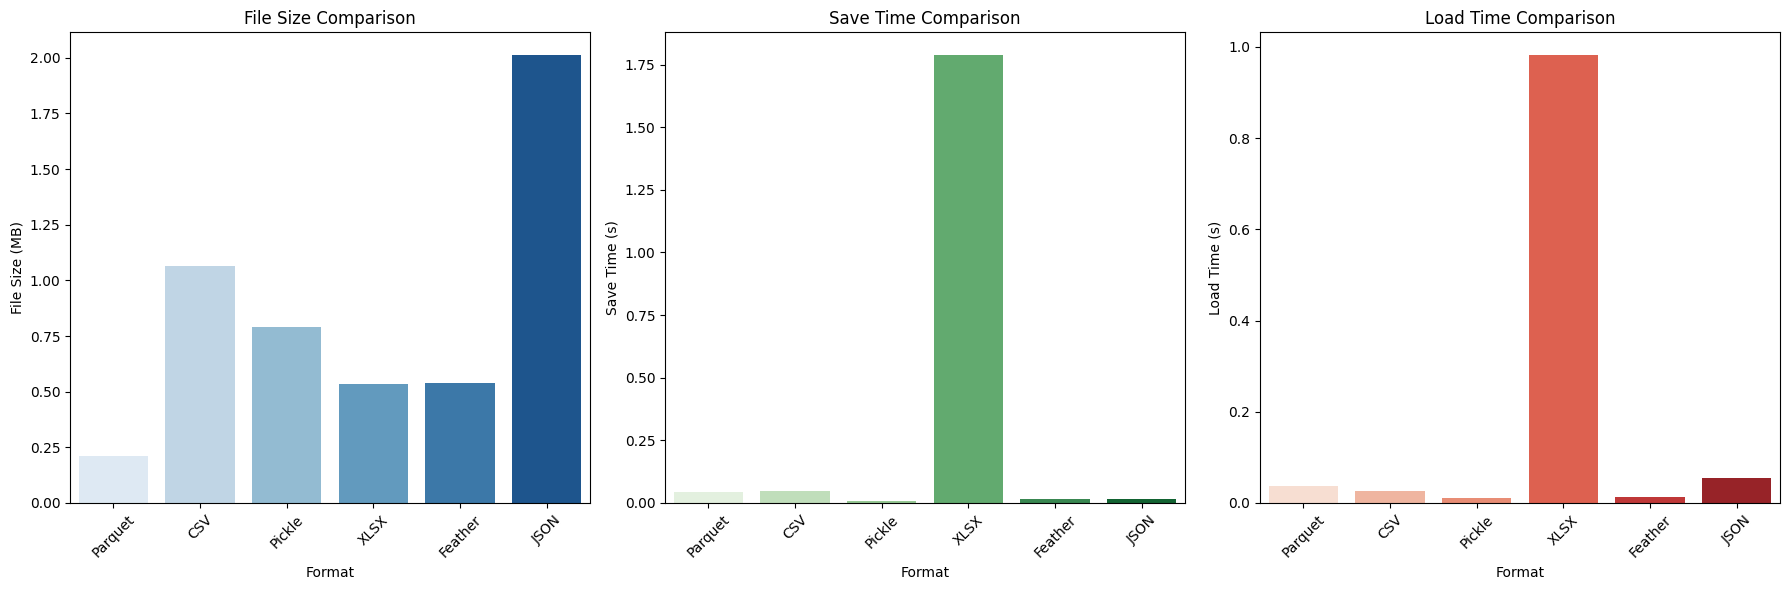

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(18, 6))

### Visualization 1: File Size for Each Format ###
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x="Format", y="File Size (MB)", hue="Format", palette="Blues", dodge=False)
plt.legend([], [], frameon=False)  # Hides legend
plt.title("File Size Comparison")
plt.xticks(rotation=45)
plt.xlabel("Format")
plt.ylabel("File Size (MB)")

### Visualization 2: Save Time for Each Format ###
plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x="Format", y="Save Time (s)", hue="Format", palette="Greens", dodge=False)
plt.legend([], [], frameon=False)  # Hides legend
plt.title("Save Time Comparison")
plt.xticks(rotation=45)
plt.xlabel("Format")
plt.ylabel("Save Time (s)")

### Visualization 3: Load Time for Each Format ###
plt.subplot(1, 3, 3)
sns.barplot(data=results_df, x="Format", y="Load Time (s)", hue="Format", palette="Reds", dodge=False)
plt.legend([], [], frameon=False)  # Hides legend
plt.title("Load Time Comparison")
plt.xticks(rotation=45)
plt.xlabel("Format")
plt.ylabel("Load Time (s)")

plt.tight_layout()
plt.show()

Pickle and Feather are slightly better in Save and Load Time Comparison, but Parquet File Size is 2-3 times smaller than those two. So let's stick to parque for this project! See you in the next chapter: Visualization.

PS. If you want to gather the data from EIPA, just register your account on EIPA's site and you will get the tokens :) 